<a href="https://colab.research.google.com/github/hoangdungnguyen/XVA-stage/blob/master/Pricing_dim10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pricing problem with randomized neural networks (dim = 10)

**Description:** 
We consider a portfolio of $d$ calls with the following parameters:
* Constant risk-free rate  $r =0.025$
* Time to maturity $T = 0.5$
* For $i = 1,\dots,d$, 
    * Call strikes: $K^i \overset{\text{iid}}{\sim} Uniform([80,120])$
    * Call volatilities: $\sigma^i \overset{\text{iid}}{\sim} Uniform([0.1, 0.5])$
    * Call weights: $\omega^i \overset{\text{iid}}{\sim} Uniform([0, 1])$.

The input is the vector of initial underlying prices $S_0 = [S_0^1 \dots S_0^{d}]$ such that $S_0^{i=1,\dots,d} \sim Uniform([10+5i, 180+5i])$. The output value is the portfolio price calculated by discounted payoff and Black-Scholes stock prices:
    $$\pi = e^{-rT} \sum_{i=1}^{d} \omega^i \left(S_T^i - K^i \right)^+$$
where 
\begin{equation*}
    S_T^i = S_0^i \exp\left( rT - \frac{1}{2} (\sigma^i)^2T + \sigma^i\sqrt{T} \epsilon \right) \quad \mbox{for} \quad \epsilon \sim \mathcal{N}(0,1)
\end{equation*}
For the sake of efficiency in neural network framework, the input is normalized by its empirical mean and standard error over training set and the output is scaled by its standard error of training set. In addition, the data shape of traing (also test) data is examined for pricing problem: $n = 50,000 \times d = 10$.

**Benchmarking:** Training algorithms are benchmarked by the normalized root-mean-square error \begin{equation}
NRMSE (\hat{y}_{1:n}, y_{1:n}) = \frac{\sqrt{\frac{1}{n}\sum_{i=1}^{n} (\hat{y}_i - y_i)^2}}{std(y_{1:n})}
\end{equation}
where $n$ denotes the number of test sample, $y$ and $\hat{y}$ are the targets and its predictions. The target that we want to approach in the pricing problem  is the analytical B\&S call prices defined as follows:
\begin{equation}
    \pi^{BS} = \sum_{i=1}^{d} \omega^i \left(S_0^i\Phi(d_1^i) - K_i e^{-rT}\Phi(d^i_2)\right)
\end{equation}
where $\Phi(\cdot)$ is the cumulative distribution function of the standard normal distribution and 
\begin{align*}
    d_1^i &= \frac{1}{\sigma^i\sqrt{T}} \left[\ln \left( \frac{S_0^i}{K^i}\right) + \left(r + \frac{(\sigma^i)^2}{2}\right)T\right] \\
    d_2^i &= d_1^i - \sigma^i\sqrt{T}
\end{align*}
Note that the B\&S price is the true conditional expectation which will not be neither used for training nor for tuning models.

**Outline:**
* Model setup and hyper parameter spaces are specified in Section 0 
* We code classes and functions in Section 1 to 3
* Hyper parameter optimisations are implemented in Section 4 to 6
* Section 7 benchmarks models

---



Before starting, we need to install ```cuml``` by the following cell. This is a new GPU-accelerated machine learning platform developed by NVIDIA team, which does the linear regression (i.e. matrix inversion) much faster than Scikit-learn and more stably than PyTorch.

**Attention:** The installation may take several minutes (~ 10m).



In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 185 (delta 5), reused 0 (delta 0), pack-reused 171
Receiving objects: 100% (185/185), 57.14 KiB | 11.43 MiB/s, done.
Resolving deltas: 100% (67/67), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT CHANGES: RAPIDS on Colab will be pegged to 0.14 Stable until further notice.
2. Default stable version is now 0.14.  Nightly will redirect to 0.14.
3. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.13 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rap

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

import cuml
import numpy as np
import time
import sys, gc
import seaborn as sns
import random
from itertools import chain
from tqdm.notebook import tqdm
import math
import scipy as si
from scipy.stats import norm
import pandas as pd
import tensorflow as tf
import tensorflow.compat.v1 as tf1
from sklearn.preprocessing import PolynomialFeatures
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import torch 
from torch import matmul
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import torch.distributions as tdist

#from kmeans_pytorch import kmeans

print('GPU available: ',torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU available:  True


#0 Model parameters and Hyper parameters

We define model parameters and hyper parameter spaces which are used for tuning models.

In [ ]:
### Model parameters
dim_X = 10 # Input dimension
T = 0.5 # Time to Maturity
r = 0.025 # Risk-free rate
N_sim = 50000 # Number of simulations

K_low = 80
K_high = 120

sigma_low = 0.1
sigma_high = 0.5
omega_low = 0.
omega_high = 1.

### Hyper parameters 
Kfold = 3 # Number of folds in the cross validation for hyper parameter tuning 
max_epochs = 300 # Max epochs for Gradient methods (training NN)

learning_rate = hp.choice('learning_rate',[0.001,0.01,0.1,0.5,1])
batchsize = hp.choice('batchsize',[1000, 5000, N_sim])
unit_num = hp.choice('unit_num',[10,20,50,100])
hlayer_num = hp.choice('layer_num',[1,2])
regularization_weight = hp.choice('regularization_weight',[0,0.1,0.5,1])
activation = hp.choice('activation', [F.relu, F.sigmoid, F.softplus, F.elu])

space_NN = {
    'learning_rate': learning_rate,
    'batch_size': batchsize,
    'unit_num': unit_num,
    'hlayer_num': hlayer_num,
    'regularization_weight': regularization_weight,
    'activation': activation
}

space_ELM = {
    'unit_num': hp.choice('unit_num',[20,50,100,200]),
    'projection': hp.choice('projection', ['Gauss', 'Rademacher', 'Achlioptas']),
    'regularization_weight': regularization_weight,
    'activation': activation
}

space_RBF = {
    'unit_num': hp.choice('unit_num',[20,50,100,200]),
    'regularization_weight': regularization_weight,
    'activation': hp.choice('activation', ['Gaussian', 'Multiquadric', 'Inverse quadratic', 'Thin plate spline']),
    'shape_para': hp.choice('shape_para',[.1,0.5,1,2,5,10])
}

# 1 Data simulator

We define a class which allow us to generate data for the pricing problem.

In [ ]:
class call_pricing_generator:
    """ 
    Data generator for pricing problem

    call_pricing_generator simulates a matrix of initial underlying prices as
    input, a vector of portfolio price calculated by discounted payoff as output 
    and a vector of portfolio price calculated by  analytical B&S call prices
    for benchmark.  

    Parameters
    ----------
    dim_X : int, default= Model parameters
        Dimension of input features
    T : float, default= Model parameters
        Time to maturity of call portfolio
    r : float, default= Model parameters
        Constant risk-fee rate
    K_low : float, default= Model parameters
        Lower bound of call strikes
    K_high : float, default= Model parameters
        Upper bound of call strikes
    sigma_low : float, default= Model parameters
        Lower bound of call volatilities
    sigma_high : float, default= Model parameters
        Upper bound of call volatilities
    omega_low : float, default= Model parameters
        Lower bound of call weights in the portfolio
    omega_high : float, default= Model parameters
        Upper bound of call weights in the portfolio
    random_state : int, default= None
        Determines random number generation for call parameters
        (strike, volatilitie and weight in the portfolio).     
    Attributes
    ----------
    dim_X : int
    T : float
    r : float
    K : array, shape (dim_X,)
        The call strike vectors drawn independently from 
        U[K_low, K_high]
    sigma : array, shape (dim_X,)
        The call volatility vectors drawn independently from 
        U[sigma_low, sigma_high]
    omega : array, shape (dim_X,)
        The call weight vectors drawn independently from 
        U[omega_low, omega_high]. The sum of weights can be greater than 1 or 
        smaller than 0.
    Notes
    ----------
    Data is sumulated on CPU.    
    """
    def __init__(self, dim_X = dim_X, T = T, r = r, 
                 K_low = K_low, K_high = K_high,
                 sigma_low = sigma_low, sigma_high = sigma_high,
                 omega_low = omega_low, omega_high = omega_high,
                 random_state = None):
        self.dim_X = dim_X
        self.K = np.random.RandomState(random_state).uniform(K_low, K_high, dim_X)
        self.T = T
        self.r = r
        self.sigma = np.random.RandomState(random_state).uniform(sigma_low, sigma_high, dim_X)
        self.omega = np.random.RandomState(random_state).uniform(omega_low,omega_high, dim_X)
  
    def print_para(self):
        """
        Print model setup parameters.
        """
        return {'dim_X': self.dim_X, 'K': self.K, 'T': self.T, 'r': self.r, 
                'sigma': self.sigma, 'omega': self.omega}

    def simulate(self, N_sim = N_sim, random_state = None):
        """
        Simulate data and wrap to torch.Tensor.
        Parameters
        ----------
        N_sim : int, default= Model parameters
            Number of observations to simulate.
        random_state : int, default= None
            Determines random number generation for data creation.
        Returns
        -------
        X : torch.Tensor, shape (N_sim, dim_X)
            Matrix of initial underlying prices as input
        Y : torch.Tensor, shape (N_sim, 1) 
            Vector of portfolio price calculated by discounted payoff as output
        price : torch.Tensor, shape (N_sim, 1)
            Vector of portfolio price calculated by  analytical B&S call prices
            for benchmark. 
        """
        payoff = np.zeros([N_sim, self.dim_X])
        price = np.zeros([N_sim, self.dim_X])
        S0 = np.zeros([N_sim, self.dim_X])
        for i in range(self.dim_X):
            S0[:,i] = np.random.RandomState(random_state).uniform(10+i*5, 180+i*5, N_sim)
            ST = S0[:,i]*np.exp((self.r-0.5*self.sigma[i]**2)*self.T+self.sigma[i]*np.sqrt(self.T)*np.random.normal(size=N_sim))
            payoff[:,i] = np.exp(-self.r*self.T)*np.maximum(ST-self.K[i], 0)
            d1 = (np.log(S0[:,i]/self.K[i])+(self.r+0.5*self.sigma[i]**2)*self.T)/(self.sigma[i]*np.sqrt(self.T))
            d2 = d1 - self.sigma[i]*np.sqrt(self.T)
            price[:,i] = S0[:,i]*norm.cdf(d1)-np.exp(-self.r*self.T)*self.K[i]*norm.cdf(d2)
            
        payoff = np.sum(payoff*self.omega, axis = 1)
        price = np.sum(price*self.omega, axis = 1)

        X = torch.from_numpy(S0.reshape(-1,self.dim_X)).type(torch.FloatTensor)
        Y = torch.from_numpy(payoff.reshape(-1,1)).type(torch.FloatTensor)
        price = torch.from_numpy(price.reshape(-1,1)).type(torch.FloatTensor)

        return (X, Y, price)

#2 Randomized layers

Two design for randomized layers: Random projection (ELM) and RBF function

In [ ]:
class Rademacher_dist:
    """ 
    Rademacher distribution

    Rademacher_dist is a generator of Rademacher distribution taking values 
    +1 and −1 with probability 1/2 for each. Rademacher_dist serves to create 
    random projection matrix.
    """
    def sample(dim):
        """
        Simulate data drawn from Rademacher distribution.

        Parameters
        ----------
        dim : list
            Shape of simulated data.
        Returns
        -------
        Generated data whose the shape = dim.
        """
        return 2*tdist.bernoulli.Bernoulli(0.5).sample(dim)-1
class Achlioptas_dist:
    """ 
    Achlioptas distribution

    Achlioptas_dist is a generator of Rademacher distribution taking values 
    +√3, 0 and −√3 with probability 1/6, 2/3, 1/6 respectively. Rademacher_dist 
    serves to create random projection matrix.  
    """
    def sample(dim):
        """
        Simulate data drawn from Achlioptas distribution.
        
        Parameters
        ----------
        dim : list
            Shape of simulated data.
        Returns
        -------
        Generated data whose the shape = dim.
        """
        return (tdist.categorical.Categorical(probs=torch.tensor([1/6,2/3,1/6])).sample(dim) -1)*np.sqrt(3)

class Randomprojection:
    """ 
    Random projection mapping

    Randomprojection maps the input data into a new dimentional space, a bias 
    term can be added to transformed data, and then an activation function can 
    be applied. Randomprojection can transform the data several times but it is 
    not necessary.

    Parameters
    ----------
    Layers : list, default= [10,100]
        The first element of this list is the dimension of input, the second 
        element is the dimension of new space. If the length of list d is more
        than two, this means the transformation is applied d-1 times into the 
        corresponding dimension of new spaces. 
    bias : bool, default= True
        Whether to apply the intercept for the transformation.
    activation : function, default= F.relu
        Activation function.
    projection : string, default = 'Gauss'
        The distribution of Random projection: 'Gauss' for Gaussian distribution,
        'Rademacher' for Rademacher distribution and 'Achlioptas' for Achlioptas 
        distribution.        
    random_state : int, default= None
        Determines random number generation for random projection matrix.     
    Attributes
    ----------
    dist : distribution
        Random projection distribution.
    W : list
        List of weights (cf. Random projection matricies). The length of this
        list is equal to the one of Layers minus one.
    b : list
        List of biases. It is empty if bias = False
    activation : function
        Activation function.
    bias : bool
        Whether to apply the intercept for the transformation.
    """
    def __init__(self, Layers = [10, 100], bias = True, activation = F.relu, projection = 'Gauss', random_state = None):
        if projection == 'Gauss':
            dist = tdist.normal.Normal(0., 1.)
        elif projection == 'Rademacher':
            dist = Rademacher_dist
        elif projection == 'Achlioptas':
            dist = Achlioptas_dist

        self.W, self.b =[], []
        if random_state == None:
            for input_size, output_size in zip(Layers, Layers[1:]):
                self.W.append(dist.sample((input_size, output_size)))
                if bias:
                    self.b.append(tdist.normal.Normal(0., 1.).sample((output_size,)))
        else:
            for i,input_size, output_size in zip(range(len(Layers)-1),Layers, Layers[1:]):
                torch.manual_seed(random_state+i)
                self.W.append(dist.sample((input_size, output_size)))
                if bias:
                    torch.manual_seed(2*random_state+i)
                    self.b.append(tdist.normal.Normal(0., 1.).sample((output_size,)))

        self.activation = activation
        self.bias = bias
    def fit_transform(self, X):
        """
        Transform input X with specified setup.

        Parameters
        ----------
        X : torch.Tensor, shape = X.shape
            Input data.
        Returns
        -------
        Transformed data whose the shape = (X.shape[0], Layers[-1])
        """
        X = X.to(device)
        if self.bias:
            for W,b in zip(self.W, self.b):
                X = self.activation(torch.matmul(X, W.to(device)) + b.to(device))
        else :
            for W in self.W:
                X = self.activation(torch.matmul(X, W.to(device)))
        return X

In [ ]:
from cuml.cluster import KMeans

class RBFlayer:
    """
    Radial basis function layer

    RBFlayer allows to transform data by Radial basis functions with four 
    selections detailed in below. Central vectors are selected by using 
    K-Means clustering directly on the input data.

    Parameters
    ----------
    output_layer : int, default = 100
        Dimension of transformed data
    e : float, default = 1/2
        Hyper parameter of Radial basis function (when function in ['Gaussian', 
        'Multiquadric', 'Inverse quadratic']).
    function : 
        Radial basis function with four selections: 
        'Gaussian', 'Multiquadric', 'Inverse quadratic' or 'Thin plate spline'.
    Attributes
    ----------
    K : int
        Dimension of transformed data (cf. RBF layer units).
    activation : function
        Activation function.
    """

    def __init__(self, output_layer = 100, e = 1/2, function = 'gaussian'):
        self.K = output_layer
        if function.capitalize() == 'Gaussian' :
            self.activation = lambda x: torch.exp(-e*x)
        elif function.capitalize() == 'Multiquadric':
            self.activation = lambda x: torch.sqrt(1+e*x)
        elif function.capitalize() == 'Inverse quadratic':
            self.activation = lambda x: 1/(1+e*x)
        elif function.capitalize() == 'Thin plate spline':
            self.activation = lambda x: (x**2*torch.log(torch.clamp(x, min=1e-40) )).type(torch.float)


    def fit(self, X):
        """
        Fit K-means clustering by input data in order to calculate central 
        vectors. 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        Returns
        -------
        self with self.centroids which stores central vectors 
        """
        kmeans = KMeans(n_clusters=self.K, max_iter=10, oversampling_factor=1, output_type='numpy')
        kmeans.fit(X.to(device))
        self.centroids = torch.Tensor(kmeans.cluster_centers_).type(torch.float)
          
    def transform(self, X):
        """
        Transform input X with specified setup.

        Parameters
        ----------
        X : torch.Tensor, shape = X.shape
            Input data.
        Returns
        -------
        Transformed data whose the shape = (X.shape[0], self.K)
        """
        self.centroids = self.centroids.to(device)
        dist= torch.empty((X.shape[0],self.K), dtype= torch.float)
        for j in range(self.K):
            dist[:,j] = torch.norm(X - self.centroids[j], dim = 1)
        return self.activation(dist**2)


#3 Readout layers

Here we define standard NN and Linear Regression for training Readout layer of Randomized NN.

In [ ]:
class LR_readout_cuml:
    """
    Linear regression (for readout layer) by matrix inversion 

    LR_readout_cuml performs linear regression using the fast GPU matrix 
    inversion in cuml package.

    Parameters
    ----------
    intercept : bool, default = True
        Whether to compute the intercept for this model.
    normalize : bool, default = False
        Whether to normalize the input matrix X.
    regularization_weight : float, defalut = 0 
        Regularization strength. Larger values specify stronger regularization.
    Attributes
    ----------
    lin_reg : Linear regression model
    """
    
    def __init__(self, intercept = True, normalize=False, regularization_weight = 0):
        if regularization_weight == 0:
            self.lin_reg = cuml.LinearRegression(fit_intercept=intercept, normalize=normalize,
                                                 output_type='numpy')
        else:
            self.lin_reg = cuml.Ridge(alpha=regularization_weight, 
                                      fit_intercept=intercept, normalize=normalize, 
                                      output_type='numpy')

    def fit(self, X, y):
        """
        Fit Regression model. 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        y : torch.Tensor
            Output matrix (vector).
        Returns
        -------
        self with self.lin_reg is fitted 
        """
        self.lin_reg.fit(X,y)
        
    def predict(self, X) :
        """
        Predict output by input matrix X and fitted model. 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        Returns
        -------
        y : torch.Tensor
            Output matrix (vector).
        """
        return torch.from_numpy(self.lin_reg.predict(X)).type(torch.FloatTensor).to(device)

    def l2_loss(self,X, y, weight = 1):
        """
        Compute quadratic loss for prediction from input X and true output y . 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        y : torch.Tensor
            True output matrix (vector).
        Returns
        -------
        Qudratic loss
        """
        return torch.mean((self.predict(X)*weight - y.reshape(-1))**2)

In [ ]:
class NN_nlayers(nn.Module):
    """
    Neural network model 

    Parameters
    ----------
    Layers : list
        List of layers. The first and last element of list are input and output
        units which are fixed by the model setup. The mid elements specify units
        of hidden layers. For example, Layers =[40,50,80,1] means NN inputing 
        40-dimension vector and outputing a value with 2 hidden layers of 50 and
        80 units, respectively.  
    activation : function, default = F.relu
        Activation function.
    Attributes
    ----------
    hidden : list
        List of hidden layers. 
    activation: function
        Activation function.
    """

    def __init__(self, Layers, activation = F.relu):
        super(NN_nlayers, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

        self.activation = activation

    def forward(self, x):
        """
        Perform the calculation by Neural network model 

        Parameters
        ----------
        x : torch.Tensor
            Input matrix.
        Returns
        ----------
        output  torch.Tensor calculated by Neural network model
        """
        x = x.to(device)
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

Let's define training quadratic function for NN Pytorch

In [ ]:
def train_quad_loss(model, train_loader, learning_rate = 0.1, regularization_weight = 0, 
                    epochs=300, verbose = None):
    """
    Train quadratic loss function

    This function trains Pytorch neural network module by Adam optimizer and
    batch gradient descent. 
    
    Parameters
    ----------
    model : torch.nn.Module
        Neural network model
    train_loader : torch.utils.data.DataLoader
        DataLoader of Pytorch containing training data which is partitioned in 
        batches.
    learning_rate : float, default = 0.1
        Learning rate of Adam optimizer
    regularization_weight : float, default = 0
        Regularization weight. Larger values specify stronger regularization.
    epochs : int,  default = 300
        Number of iterations doing parameters update.
    verbose : int, default = None
        The verbosity level of training loss function. If None, nothing is printed.
    Returns
    -------
    model is trained. 
    """
    train_loss_list = []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization_weight)
    i = 0
    
    for epoch in range(epochs):
        correct = 0
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch,y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = F.mse_loss(pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss
        train_loss_list.append(total_loss)
        if verbose != None : 
            if epoch % verbose == 0:
                print('[iter {}] training error = {}'.format(epoch, round(train_loss_list, 3)))
    model.eval()


Let's simulate data. The input matrix (in both training and test sets) is then normalized by its empirical mean and standard error over training set and the output is scaled by its standard error of training set. **For the moment, all data sets are stored on CPU**.

In [ ]:
Pricing_Generator = call_pricing_generator(dim_X = dim_X)

S0_train, payoff_train, price_BS_train = Pricing_Generator.simulate(N_sim = N_sim)
S0_test, payoff_test, price_BS_test = Pricing_Generator.simulate(N_sim = N_sim)

X_train = (S0_train - S0_train.mean(axis = 0))/S0_train.std(axis = 0)
X_test = (S0_test - S0_train.mean(axis = 0))/S0_train.std(axis = 0)

y_train = payoff_train/payoff_train.std()

# 4 Neural networks

We now define score metric (MSE between the prediction and BS analytical price) and structure training objective for fine tuning.

In [ ]:
def score_func(model, x_val, y_BS_val):
    """
    Score function for tuning network hyper parameters 
    """
    return  F.mse_loss(model(x_val)*float(payoff_train.std()), y_BS_val).item()


def objective(params):
    time1 = time.time()

    print("\n############## New Run ################")
    print(f"params = {params}")
    count = 1
    kf = KFold(n_splits=Kfold)

    score_sum = 0
    # Loop over each fold
    for tr_idx, val_idx in kf.split(X_train):
        # Partition data into batches
        train_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_train[tr_idx, :], y_train[tr_idx]),
            batch_size = params['batch_size'], shuffle = True)      
        
        # Define andt train NN model 
        var_NN = NN_nlayers(Layers=[dim_X]+[params['unit_num']]*params['hlayer_num']+[1], 
                            activation = params['activation']).to(device)
        train_quad_loss(var_NN, train_loader, params['learning_rate'], params['regularization_weight'], epochs= max_epochs)

        # Score on validation fold
        X_val,y_val = X_train[val_idx, :].to(device), price_BS_train[val_idx].to(device)
        score = score_func(var_NN, X_val,y_val)

        # Sum score over cross validation
        score_sum += score
        print(f' CV {count} - score: {round(score, 4)}')
        count += 1

        # Delete done variables on GPU to save memory
        del train_loader, X_val,y_val, var_NN
        torch.cuda.empty_cache()
        gc.collect()
        
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2,0)}")
    
    print(f'Mean score: {score_sum / Kfold}')
    
    return (score_sum / Kfold)

Using ```hyperopt``` package to perform hyper parameter tuning by Random search with suggestion.

In [ ]:
%%time
# Set algoritm parameters 
best = fmin(fn=objective,
            space=space_NN,
            algo=tpe.suggest,
            max_evals=30)

# Print best parameters
best_params_NN = space_eval(space_NN, best)



############## New Run ################
params = {'activation': <function sigmoid at 0x7fc911ee6840>, 'batch_size': 50000, 'hlayer_num': 2, 'learning_rate': 0.001, 'regularization_weight': 0, 'unit_num': 100}
 CV 1 - score: 351.0634
 CV 2 - score: 650.5066
 CV 3 - score: 538.614
Total Time Run: 340.0
Mean score: 513.3946329752604

############## New Run ################
params = {'activation': <built-in function softplus>, 'batch_size': 50000, 'hlayer_num': 1, 'learning_rate': 0.1, 'regularization_weight': 0, 'unit_num': 100}
 CV 1 - score: 32.4292
 CV 2 - score: 28.4276
 CV 3 - score: 28.5331
Total Time Run: 340.0
Mean score: 29.796628952026367

############## New Run ################
params = {'activation': <built-in function softplus>, 'batch_size': 50000, 'hlayer_num': 1, 'learning_rate': 0.1, 'regularization_weight': 0.5, 'unit_num': 10}
 CV 1 - score: 1184.7612
 CV 2 - score: 1219.6077
 CV 3 - score: 1208.9596
Total Time Run: 344.0
Mean score: 1204.4428304036458

############## 

In [ ]:
best_params_NN

{'activation': <function torch._C._nn.softplus>,
 'batch_size': 50000,
 'hlayer_num': 1,
 'learning_rate': 0.1,
 'regularization_weight': 0,
 'unit_num': 100}

# 5 ELM networks

Now we wrap data to GPU and continue tuning for ELM and RBF networks

In [ ]:
X_train = X_train.to(device)
X_test = X_test.to(device)
payoff_train = payoff_train.to(device)
price_BS_train = price_BS_train.to(device)
payoff_test = payoff_test.to(device)
price_BS_test = price_BS_test.to(device)
y_train = y_train.to(device)

In [ ]:
def score_func(solution, x_val, y_BS_val):
    return solution.l2_loss(x_val, y_BS_val, float(payoff_train.std())).item()

def objective(params):
    time1 = time.time()

    print("\n############## New Run ################")
    print(f"params = {params}")
    count = 1
    kf = KFold(n_splits=Kfold)

    score_sum = 0

    # Define Random projection layer and Linear regression solver with specified hyper parameters
    LR_solution = LR_readout_cuml(regularization_weight= params['regularization_weight'])

    Randomprojection_layer = Randomprojection(Layers =[dim_X]+[params['unit_num']],
                                                  activation = params['activation'], projection = params['projection'])
    # Loop over each fold
    for tr_idx, val_idx in kf.split(X_train):

        # Fit Linear regression by training data and score on validation data
        LR_solution.fit(Randomprojection_layer.fit_transform(X_train[tr_idx, :]),y_train[tr_idx,:])
        
        score = score_func(LR_solution, Randomprojection_layer.fit_transform(X_train[val_idx, :]), price_BS_train[val_idx, :])

        score_sum += score
        print(f' CV {count} - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2,4)}")
    
    print(f'Mean score: {score_sum / Kfold}')
    
    #Delete variables
    del Randomprojection_layer,LR_solution
    torch.cuda.empty_cache()
    gc.collect()
    return (score_sum / Kfold)

In [ ]:
%%time

# Set algoritm parameters 
best = fmin(fn=objective,
            space=space_ELM,
            algo=tpe.suggest,
            max_evals=30)

# Print best parameters
best_params_ELM = space_eval(space_ELM, best)



############## New Run ################
params = {'activation': <built-in function softplus>, 'projection': 'Rademacher', 'regularization_weight': 1, 'unit_num': 100}
 CV 1 - score: -59.96
 CV 2 - score: -58.111
 CV 3 - score: -60.0888
Total Time Run: 9.8193
Mean score: -59.386592864990234

############## New Run ################
params = {'activation': <function relu at 0x7fc911ee5d08>, 'projection': 'Gauss', 'regularization_weight': 1, 'unit_num': 50}
 CV 1 - score: -154.3344
 CV 2 - score: -153.179
 CV 3 - score: -153.859
Total Time Run: 0.0506
Mean score: -153.7907969156901

############## New Run ################
params = {'activation': <function sigmoid at 0x7fc911ee6840>, 'projection': 'Achlioptas', 'regularization_weight': 0, 'unit_num': 20}
 CV 1 - score: -492.2259
 CV 2 - score: -495.778
 CV 3 - score: -485.252
Total Time Run: 0.0508
Mean score: -491.08530680338544

############## New Run ################
params = {'activation': <function sigmoid at 0x7fc911ee6840>, 'project

In [ ]:
best_params_ELM

{'activation': <function torch.nn.functional.elu>,
 'projection': 'Achlioptas',
 'regularization_weight': 0.1,
 'unit_num': 200}

# 6 RBF networks

In [ ]:

def score_func(solution, x_val, y_BS_val):
    return solution.l2_loss(x_val, y_BS_val, float(payoff_train.std())).item()


def objective(params):
    time1 = time.time()

    print("\n############## New Run ################")
    print(f"params = {params}")
    count = 1
    kf = KFold(n_splits=Kfold)

    score_sum = 0

    # Define RBF layer and Linear regression readout with specified hyper parameters
    LR_solution = LR_readout_cuml(intercept = False, regularization_weight= params['regularization_weight'])

    RBF_hlayer = RBFlayer(output_layer=params['unit_num'], e = params['shape_para'], function = params['activation'])
                                                  
    for tr_idx, val_idx in kf.split(X_train):
        # Fit RBF central vectors
        RBF_hlayer.fit(X_train[tr_idx, :])
        # Transform input by RBF layer
        X_batch = RBF_hlayer.transform(X_train[tr_idx, :]).to(device)
        X_val = RBF_hlayer.transform(X_train[val_idx, :]).to(device)
        
        # Fit Linear regression and score on validation data
        LR_solution.fit(X_batch,y_train[tr_idx,:])
        
        score = score_func(LR_solution, X_val, price_BS_train[val_idx, :])

        score_sum += score
        print(f' CV {count} - score: {round(score, 4)}')
        count += 1
        
        # Delete variables
        del X_val, X_batch
        torch.cuda.empty_cache()
        gc.collect()
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2,4)}")
    
    print(f'Mean score: {score_sum / Kfold}')
    
    del RBF_hlayer, LR_solution
    torch.cuda.empty_cache()
    gc.collect()
    return (score_mean / Kfold)

In [ ]:
%%time

# Set algoritm parameters 
best = fmin(fn=objective,
            space=space_RBF,
            algo=tpe.suggest,
            max_evals=30)

# Print best parameters
best_params_RBF = space_eval(space_RBF, best)



############## New Run ################
params = {'activation': 'Inverse quadratic', 'regularization_weight': 0.5, 'shape_para': 10, 'unit_num': 100}
 CV 1 - score: -3134.8882
 CV 2 - score: -3219.8306
 CV 3 - score: -3134.281
Total Time Run: 1.3428
Mean score: -3162.9999186197915

############## New Run ################
params = {'activation': 'Thin plate spline', 'regularization_weight': 1, 'shape_para': 1, 'unit_num': 20}
 CV 1 - score: -4942.5239
 CV 2 - score: -5065.9268
 CV 3 - score: -5021.9668
Total Time Run: 0.6483
Mean score: -5010.13916015625

############## New Run ################
params = {'activation': 'Thin plate spline', 'regularization_weight': 0.1, 'shape_para': 5, 'unit_num': 100}
 CV 1 - score: -555.3387
 CV 2 - score: -529.5027
 CV 3 - score: -519.3708
Total Time Run: 1.1818
Mean score: -534.7374064127604

############## New Run ################
params = {'activation': 'Inverse quadratic', 'regularization_weight': 0.1, 'shape_para': 1, 'unit_num': 100}
 CV 1 - sc

In [ ]:
best_params_RBF

{'activation': 'Multiquadric',
 'regularization_weight': 0.1,
 'shape_para': 0.1,
 'unit_num': 50}

# 7 Benchmark

One can note from hyper parameter optimization phase is that RBF networks are very sensible with the selection of hyper parameters.

Now, we benchmark each class model with its best hyper parameters. We use 10 trials for a better comparison.

In [ ]:

best_params_NN = {'activation': F.softplus,
                  'batch_size': N_sim,
                  'hlayer_num': 1,
                  'learning_rate': 0.1,
                  'regularization_weight': 0,
                  'unit_num': 100}

best_params_ELM = {'activation': F.elu,
                   'projection': 'Achlioptas',
                   'regularization_weight': 0.1,
                   'unit_num': 200}


best_params_RBF = {'activation': 'Multiquadric', 
                   'regularization_weight': 0.1, 
                   'shape_para': 0.1, 
                   'unit_num': 50}


We define a function for quickly redrawing simulation data.

In [ ]:
sys_variables = sys.modules[__name__]

def data_simulator(dim_X = dim_X, N_sim = N_sim):
    # Delete all existing variables
    try:
        del sys_variables.S0_train, sys_variables.payoff_train, sys_variables.price_BS_train
        del sys_variables.S0_test, sys_variables.payoff_test, sys_variables.price_BS_test, sys_variables.true_ES_test
        del sys_variables.X_train, sys_variables.y_train, sys_variables.X_test, sys_variables.Pricing_Generator

        
    except:
        pass
    torch.cuda.empty_cache()

    # Regenerate data
    Pricing_Generator = call_pricing_generator(dim_X = dim_X)

    S0_train, payoff_train, price_BS_train = Pricing_Generator.simulate(N_sim = N_sim)
    S0_test, payoff_test, price_BS_test = Pricing_Generator.simulate(N_sim = N_sim)
    
    X_train = (S0_train - S0_train.mean(axis = 0))/S0_train.std(axis = 0)
    X_test = (S0_test - S0_train.mean(axis = 0))/S0_train.std(axis = 0)

    sys_variables.X_train = X_train.to(device)
    sys_variables.payoff_train = payoff_train.to(device)
    sys_variables.price_BS_train = price_BS_train.to(device)

    sys_variables.X_test = X_test.to(device)
    sys_variables.payoff_test = payoff_test.to(device)
    sys_variables.price_BS_test = price_BS_test.to(device)

    sys_variables.y_train = (sys_variables.payoff_train/sys_variables.payoff_train.std()).to(device)

Our benchmarking metric

In [ ]:
def NRMSE(pred, true):
    """
    Normalized Root-Mean-Square Error
    
    It is Root-Mean-Square Error normalized by the standard error of true target.

    Parameters
    ----------
    pred : torch.Tensor
    true : torch.Tensor
    Returns
    -------
    NRMSE. 
    """
    return float(torch.sqrt(torch.mean((pred - true.reshape(pred.shape))**2))/ torch.std(true))

As the best standard networks use full batch size, we redefine a 
training function to save training time of standard NN.

In [ ]:
def train_quad_loss_fullbatch(model, X_train, y_train, learning_rate = 0.1, regularization_weight = 0, 
                    epochs=max_epochs):
    """
    Train quadratic loss function with full batchsize

    This function trains Pytorch neural network module by Adam optimizer with 
    full batch size. 
    
    Parameters
    ----------
    model : torch.nn.Module
        Neural network model
    X_train : torch.Tensor
        Training input
    y_train : torch.Tensor
        Training output
    learning_rate : float, default = 0.1
        Learning rate of Adam optimizer
    regularization_weight : float, default = 0
        Regularization weight. Larger values specify stronger regularization.
    epochs : int
        Number of iterations doing parameters update.
    Returns
    -------
    model is trained. 
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                                 weight_decay=regularization_weight)
    i = 0
    err, best_err = np.inf, np.inf
    while (abs(err) > 1e-8) and (i < epochs):
        optimizer.zero_grad()
        pred = model(X_train)
        loss = F.mse_loss(pred, y_train)

        # Save best model
        if err < best_err:
            best_err = err
            torch.save(model.state_dict(), 'best') 
        loss.backward()
        optimizer.step()
        err = loss.data.item()
        i += 1
    # Load best model
    model.load_state_dict(torch.load('best'))
    model.eval()  

In [ ]:
def run(hidden_unit = None):

    """
    This function trains all three models NN, ELM and RBF and return their metrics
    and training and predicting time. 
    
    Parameters
    ----------
    hidden_unit: int, default = None
        Number of units used in hidden layer. If None, use the best units found 
        by hyper parameter optimization for each model.
    Returns
    -------
    NRMSE and training and predicting time. 
    """
       
    ###### NN ######
    p1 = time.time()
    
     
    if hidden_unit == None:    
        var_NN = NN_nlayers(Layers=[dim_X]+[best_params_NN['unit_num']]*best_params_NN['hlayer_num']+[1], 
                                activation = best_params_NN['activation']).to(device)
    else:
        var_NN = NN_nlayers(Layers=[dim_X]+[hidden_unit]*best_params_NN['hlayer_num']+[1], 
                                activation = best_params_NN['activation']).to(device)  

    train_quad_loss_fullbatch(var_NN, X_train, y_train, learning_rate = best_params_NN['learning_rate'], 
                              regularization_weight = best_params_NN['regularization_weight'], epochs=max_epochs)

    NRMSE_NN_train = NRMSE(var_NN(X_train)*float(payoff_train.std()), price_BS_train)
    NRMSE_NN_test = NRMSE(var_NN(X_test)*float(payoff_train.std()), price_BS_test)
   
    try: 
        del var_NN
    except:
        pass
    torch.cuda.empty_cache()
    gc.collect()
    p2 = time.time()
    time_NN = p2-p1

    ###### ELM ######
    
    LR_solution = LR_readout_cuml(regularization_weight= best_params_ELM['regularization_weight'])
    if hidden_unit == None:    
        Randomprojection_layer = Randomprojection(Layers =[dim_X]+[best_params_ELM['unit_num']],
                                              activation = best_params_ELM['activation'], 
                                              projection = best_params_ELM['projection'])
    else:
        Randomprojection_layer = Randomprojection(Layers =[dim_X]+[hidden_unit],
                                              activation = best_params_ELM['activation'], 
                                              projection = best_params_ELM['projection'])
    
    
    X_train_transformed = Randomprojection_layer.fit_transform(X_train)
    X_test_transformed = Randomprojection_layer.fit_transform(X_test)

    LR_solution.fit(X_train_transformed,y_train)

    NRMSE_ELM_train = NRMSE(LR_solution.predict(X_train_transformed)*float(payoff_train.std()), price_BS_train)
    NRMSE_ELM_test = NRMSE(LR_solution.predict(X_test_transformed)*float(payoff_train.std()), price_BS_test)

    try: 
        del LR_solution, Randomprojection_layer, X_train_transformed, X_test_transformed
    except:
        pass
    torch.cuda.empty_cache()
    gc.collect()    
    p3 = time.time()

    time_ELM = p3-p2
    ###### RBF ######
    
    LR_solution = LR_readout_cuml(intercept = False,regularization_weight= best_params_RBF['regularization_weight'])

    RBF_hlayer = RBFlayer(output_layer=best_params_RBF['unit_num'], 
                          e = best_params_RBF['shape_para'], 
                          function = best_params_RBF['activation'])
    if hidden_unit == None:    
        RBF_hlayer = RBFlayer(output_layer=best_params_RBF['unit_num'], 
                          e = best_params_RBF['shape_para'], 
                          function = best_params_RBF['activation'])
    else:
        RBF_hlayer = RBFlayer(output_layer=hidden_unit, 
                          e = best_params_RBF['shape_para'], 
                          function = best_params_RBF['activation'])
                                                  
    RBF_hlayer.fit(X_train)
    X_train_transformed = RBF_hlayer.transform(X_train).to(device)
    X_test_transformed = RBF_hlayer.transform(X_test).to(device)
    LR_solution.fit(X_train_transformed,y_train)
        
    NRMSE_RBF_train = NRMSE(LR_solution.predict(X_train_transformed)*float(payoff_train.std()), price_BS_train)
    NRMSE_RBF_test = NRMSE(LR_solution.predict(X_test_transformed)*float(payoff_train.std()), price_BS_test)
    
    
    try: 
        del LR_solution, RBF_hlayer, X_train_transformed, X_test_transformed
    except:
        pass
    torch.cuda.empty_cache()
    gc.collect()

    p4 = time.time()
    time_RBF = p4-p3  
    if hidden_unit == None:   
        return [
                [NRMSE_NN_train,
                NRMSE_ELM_train,
                NRMSE_RBF_train],
                [NRMSE_NN_test,
                NRMSE_ELM_test,
                NRMSE_RBF_test],
                [time_NN,
                time_ELM,
                time_RBF]
                ]
    else:
        return [NRMSE_NN_test,
                NRMSE_ELM_test,
                NRMSE_RBF_test]

In [ ]:
result = []

for i in tqdm(range(20)):
    data_simulator()
    result.append(run())
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
result_data = pd.DataFrame(result)

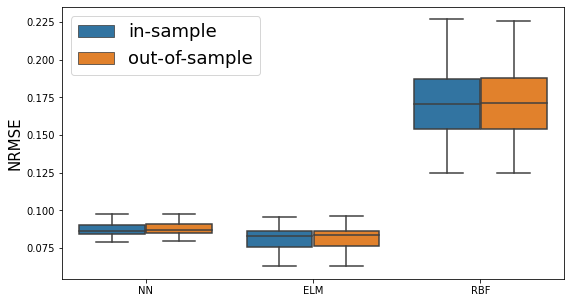

In [ ]:
NRMSE_data = list(chain.from_iterable(result_data.iloc[:,0].tolist())) + list(chain.from_iterable(result_data.iloc[:,1].tolist()))
NRMSE_data = pd.DataFrame(NRMSE_data, columns=['NRMSE'])
NRMSE_data['model'] = ['NN', 'ELM', 'RBF']*40
NRMSE_data['dataset'] = ['in-sample']*60 + ['out-of-sample']*60

plt.figure(figsize=(9,5))
sns.boxplot(x="model", y="NRMSE", hue="dataset", data=NRMSE_data, showfliers = True)
plt.xlabel("", fontsize = 12)
plt.ylabel("NRMSE", fontsize = 15)
plt.legend(fontsize = 18)

In [ ]:
NRMSE_data.groupby(['model','dataset']).agg('mean')

NRMSE
model dataset             
ELM   in-sample   0.081697
      out-sample  0.082120
NN    in-sample   0.087456
      out-sample  0.087708
RBF   in-sample   0.170560
      out-sample  0.170909

In [ ]:
Scaling_data = list(chain.from_iterable(result_data.iloc[:,2].tolist()))
Scaling_data = pd.DataFrame(Scaling_data, columns=['s'])
Scaling_data['model'] = ['NN', 'ELM', 'RBF']*20
Scaling_data.groupby('model').agg('mean')

,s
model,
ELM,0.144388
NN,0.626528
RBF,0.295635


## Density

In [ ]:
data_simulator()

In [ ]:
var_NN = NN_nlayers(Layers=[dim_X]+[best_params_NN['unit_num']]*best_params_NN['hlayer_num']+[1],
                    activation = best_params_NN['activation']).to(device)
  
train_quad_loss_fullbatch(var_NN, X_train, y_train, learning_rate = best_params_NN['learning_rate'], 
                              regularization_weight = best_params_NN['regularization_weight'], epochs=max_epochs)  

NRMSE_NN_train = NRMSE(var_NN(X_train)*float(payoff_train.std()), price_BS_train)
NRMSE_NN_test = NRMSE(var_NN(X_test)*float(payoff_train.std()), price_BS_test)

LR_solution_ELM = LR_readout_cuml(regularization_weight= best_params_ELM['regularization_weight'])    

Randomprojection_layer = Randomprojection(Layers =[dim_X]+[best_params_ELM['unit_num']],
                                      activation = best_params_ELM['activation'], 
                                      projection = best_params_ELM['projection'])



X_train_ELM = Randomprojection_layer.fit_transform(X_train)
X_test_ELM = Randomprojection_layer.fit_transform(X_test)

LR_solution_ELM.fit(X_train_ELM,y_train)

NRMSE_ELM_train = NRMSE(LR_solution_ELM.predict(X_train_ELM)*float(payoff_train.std()), price_BS_train)
NRMSE_ELM_test = NRMSE(LR_solution_ELM.predict(X_test_ELM)*float(payoff_train.std()), price_BS_test)


LR_solution_RBF = LR_readout_cuml(intercept = False,regularization_weight= best_params_RBF['regularization_weight'])

RBF_hlayer = RBFlayer(output_layer=best_params_RBF['unit_num'], 
                      e = best_params_RBF['shape_para'], 
                      function = best_params_RBF['activation'])

RBF_hlayer.fit(X_train)
X_train_RBF = RBF_hlayer.transform(X_train).to(device)
X_test_RBF = RBF_hlayer.transform(X_test).to(device)
LR_solution_RBF.fit(X_train_RBF,y_train)
    
NRMSE_RBF_train = NRMSE(LR_solution_RBF.predict(X_train_RBF)*float(payoff_train.std()), price_BS_train)
NRMSE_RBF_test = NRMSE(LR_solution_RBF.predict(X_test_RBF)*float(payoff_train.std()), price_BS_test)

  

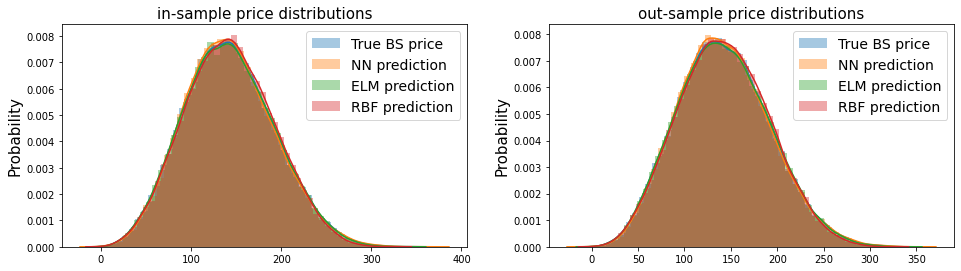

In [ ]:
plt.figure(figsize=(16,9))
plt.subplot(221)
g = sns.distplot(price_BS_train.cpu().data, label='True BS price')
g = sns.distplot((var_NN(X_train)*float(payoff_train.std())).cpu().data, label='NN prediction')
g = sns.distplot((LR_solution_ELM.predict(X_train_ELM)*float(payoff_train.std())).cpu().data, label='ELM prediction')
g = sns.distplot((LR_solution_RBF.predict(X_train_RBF)*float(payoff_train.std())).cpu().data, label='RBF prediction')

g = plt.title("in-sample price distributions", fontsize=15)
g = plt.xlabel("")
g = plt.ylabel("Probability", fontsize=15)
g = plt.legend(fontsize = 14)

plt.subplot(222)
g = sns.distplot(price_BS_test.cpu().data, label='True BS price')
g = sns.distplot((var_NN(X_test)*float(payoff_train.std())).cpu().data, label='NN prediction')
g = sns.distplot((LR_solution_ELM.predict(X_test_ELM)*float(payoff_train.std())).cpu().data, label='ELM prediction')
g = sns.distplot((LR_solution_RBF.predict(X_test_RBF)*float(payoff_train.std())).cpu().data, label='RBF prediction')

g = plt.title("out-sample price distributions", fontsize=15)
g = plt.xlabel("")
g = plt.ylabel("Probability", fontsize=15)
g = plt.legend(fontsize = 14)